In [1]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os

## GUADALUPE

In [27]:
df = pd.read_csv('data/guadalupe_processed.csv')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
if 'Date_Time' in df:
    df.set_index('Date_Time', inplace =True)
    df.index =pd.to_datetime(df.index)
    df.sort_index(axis=0,inplace= True)

In [29]:
df.columns

Index(['Type', 'Freq', 'ATAvg', 'ATMax', 'ATMin', 'PAvg', 'RHAvg', 'RHMax',
       'RHMin', 'WDAvg', 'WDMax', 'WDMin', 'WSAvg', 'WSMax', 'WSMin',
       'Preipitacion', 'station', 'validated_range', 'WDcorr', 'WDcorr_abs',
       'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [30]:
df= df[['ATAvg','PAvg','RHAvg','WDAvg','WSAvg']]

In [31]:
df = df.replace('?', np.nan)
df.isnull().sum()

ATAvg    0
PAvg     0
RHAvg    0
WDAvg    0
WSAvg    0
dtype: int64

In [32]:
## resample to hour
dfh = df.resample('60min').mean()
pavg = df.resample('60min').sum()
dfh['PAvg'] = pavg['PAvg']
dfh.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-01-11 00:00:00,13.443333,0.0,93.861667,198.515000,0.403333
2013-01-11 01:00:00,12.983333,0.0,94.390000,217.556667,0.516667
2013-01-11 02:00:00,12.495000,0.0,96.249167,141.966667,0.661667
2013-01-11 03:00:00,12.270833,0.0,95.906667,66.167500,1.156667
2013-01-11 04:00:00,12.098333,0.0,91.040833,133.720000,1.120833


In [33]:
# Split in train/test  at 75% 25%
train_df,test_df = dfh[0:round(len(dfh)*0.75)], dfh[round(len(dfh)*0.75):] 

In [ ]:
### Scale the values (-1 to 1)
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [73]:
test.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2018-04-13 22:00:00,-0.184687,-1.0,0.799282,0.160198,-0.878518
2018-04-13 23:00:00,-0.177157,-1.0,0.758845,0.181630,-0.880516
2018-04-14 00:00:00,-0.233735,-1.0,0.838563,-0.105185,-0.878700
2018-04-14 01:00:00,-0.259718,-1.0,0.875864,-0.329415,-0.752678
2018-04-14 02:00:00,-0.280070,-1.0,0.891832,-0.130911,-0.809697


In [74]:
train.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-01-11 00:00:00,-0.281495,-1.0,0.847971,0.192203,-0.912112
2013-01-11 01:00:00,-0.318942,-1.0,0.861051,0.308467,-0.887416
2013-01-11 02:00:00,-0.358696,-1.0,0.907078,-0.153070,-0.855820
2013-01-11 03:00:00,-0.376945,-1.0,0.898599,-0.615884,-0.747957
2013-01-11 04:00:00,-0.390988,-1.0,0.778135,-0.203422,-0.755765


In [37]:
### Convert Series to samples
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
    return np.array(X), np.array(y)

In [72]:
dfh.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-01-11 00:00:00,-0.281495,-1.0,0.847971,0.192203,-0.912112
2013-01-11 01:00:00,-0.318942,-1.0,0.861051,0.308467,-0.887416
2013-01-11 02:00:00,-0.358696,-1.0,0.907078,-0.153070,-0.855820
2013-01-11 03:00:00,-0.376945,-1.0,0.898599,-0.615884,-0.747957
2013-01-11 04:00:00,-0.390988,-1.0,0.778135,-0.203422,-0.755765


In [39]:
n_past = 120
n_future = 48 
n_features = 5

In [40]:
X_train, y_train = split_series(train.values,n_past, n_future+1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future+1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [41]:
print(f'Xtrain size = {X_train.shape}')
print(f'Ytrain size = {y_train.shape}')
print(f'Xtest size = {X_test.shape}')
print(f'Ytest size = {y_test.shape}')

Xtrain size = (1, 120, 5)
Ytrain size = (1, 48, 5)
Xtest size = (1, 120, 5)
Ytest size = (1, 48, 5)


In [42]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42400       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 48, 100)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 48, 100)      80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [43]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 120, 100), ( 42400       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 48, 100)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [70]:
X_test.shape

(1, 120, 5)

In [68]:
import time
start_time = time.time()
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
print(f'{round((time.time() - start_time),2)} s or {round((time.time() - start_time)/60,2)} min')

8.11 s or 0.14 min


In [ ]:
start_time = time.time()
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
print(f'{round((time.time() - start_time)/60,2)} min')

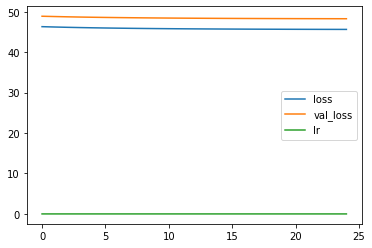

In [71]:
losses = pd.DataFrame(model_e1d1.history.history)
losses.plot()

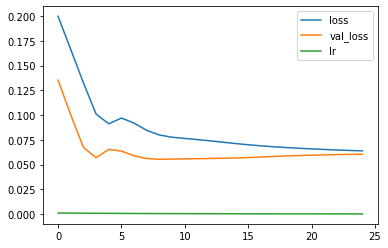

In [46]:
losses = pd.DataFrame(model_e2d2.history.history)
losses.plot()

In [47]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [48]:
### Inverse scaling of the predicted values
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    #pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    #pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [49]:
## Check error
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
    print(i)
    for j in [0,6,12,24,48]:
        print("at ",j,"h:")
        print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
    print()
    print()

ATAvg
at  0 h:
MAE-E1D1 :  1.612571029663087, MAE-E2D2 :  1.2891400146484386
at  6 h:
MAE-E1D1 :  2.1503404617309556, MAE-E2D2 :  5.871388816833495
at  12 h:
MAE-E1D1 :  1.824923426310221, MAE-E2D2 :  0.9275616709391272
at  24 h:
MAE-E1D1 :  3.0933006032307944, MAE-E2D2 :  2.6880367024739584
at  48 h:
MAE-E1D1 :  1.612571029663087, MAE-E2D2 :  1.2891400146484386


PAvg
at  0 h:
MAE-E1D1 :  0.4458346664905548, MAE-E2D2 :  0.5045493245124817
at  6 h:
MAE-E1D1 :  1.9379273653030396, MAE-E2D2 :  0.8988102674484253
at  12 h:
MAE-E1D1 :  0.8309270143508911, MAE-E2D2 :  0.37352481484413147
at  24 h:
MAE-E1D1 :  0.4905948042869568, MAE-E2D2 :  0.5330395102500916
at  48 h:
MAE-E1D1 :  0.4458346664905548, MAE-E2D2 :  0.5045493245124817


RHAvg
at  0 h:
MAE-E1D1 :  5.125492248535153, MAE-E2D2 :  9.586979064941403
at  6 h:
MAE-E1D1 :  4.8002894083658845, MAE-E2D2 :  2.025401814778647
at  12 h:
MAE-E1D1 :  21.338782653808607, MAE-E2D2 :  17.88182006835939
at  24 h:
MAE-E1D1 :  8.235795898437487, MA

## AEROPUERTO

In [4]:
df = pd.read_csv('data/aeropuerto_processed.csv')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
if 'Date_Time' in df:
    df.set_index('Date_Time', inplace =True)
    df.index =pd.to_datetime(df.index)
    df.sort_index(axis=0,inplace= True)

In [6]:
df.columns

Index(['Type', 'Freq', 'ATAvg', 'ATMax', 'ATMin', 'PAvg', 'RHAvg', 'RHMax',
       'RHMin', 'WDAvg', 'WDMax', 'WDMin', 'WSAvg', 'WSMax', 'WSMin', 'BAT',
       'station', 'validated_range', 'year', 'month', 'day', 'hour', 'minute',
       'WDcorr', 'WDcorr_abs'],
      dtype='object')

In [7]:
df= df[['ATAvg','PAvg','RHAvg','WDAvg','WSAvg']]

In [8]:
df = df.replace('?', np.nan)
df.isnull().sum()

ATAvg    0
PAvg     0
RHAvg    0
WDAvg    0
WSAvg    0
dtype: int64

In [9]:
## resample to hour
dfh = df.resample('60min').mean()
pavg = df.resample('60min').sum()
dfh['PAvg'] = pavg['PAvg']
dfh.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-03-19 21:00:00,10.210222,0.0,91.747889,113.840,0.80
2013-03-19 22:00:00,10.091000,0.0,92.442667,121.850,0.83
2013-03-19 23:00:00,10.488333,0.0,91.371167,137.505,0.86
2013-03-20 00:00:00,10.345333,0.0,91.590000,145.045,0.82
2013-03-20 01:00:00,9.946000,0.0,92.781667,143.450,0.76


In [10]:
# Split in train/test  at 75% 25%
train_df,test_df = dfh[0:round(len(dfh)*0.75)], dfh[round(len(dfh)*0.75):] 

In [ ]:
### Scale the values (-1 to 1)
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [12]:
test.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2018-04-27 19:00:00,-0.119514,-1.000000,0.655233,-0.237784,-0.554171
2018-04-27 20:00:00,-0.154611,-1.000000,0.668925,-0.091556,-0.540897
2018-04-27 21:00:00,-0.172465,-1.000000,0.780082,-0.472192,-0.688145
2018-04-27 22:00:00,-0.177828,-0.981982,0.858764,0.069984,-0.731032
2018-04-27 23:00:00,-0.202810,-0.945946,0.897047,-0.051107,-0.765751


In [13]:
train.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-03-19 21:00:00,-0.402310,-1.0,0.797496,-0.330929,-0.803942
2013-03-19 22:00:00,-0.412023,-1.0,0.814138,-0.283728,-0.796589
2013-03-19 23:00:00,-0.379654,-1.0,0.788473,-0.191477,-0.789237
2013-03-20 00:00:00,-0.391304,-1.0,0.793715,-0.147046,-0.799040
2013-03-20 01:00:00,-0.423835,-1.0,0.822257,-0.156445,-0.813745


In [14]:
### Convert Series to samples
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
    return np.array(X), np.array(y)

In [15]:
dfh.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-03-19 21:00:00,-0.402310,-1.0,0.797496,-0.330929,-0.803942
2013-03-19 22:00:00,-0.412023,-1.0,0.814138,-0.283728,-0.796589
2013-03-19 23:00:00,-0.379654,-1.0,0.788473,-0.191477,-0.789237
2013-03-20 00:00:00,-0.391304,-1.0,0.793715,-0.147046,-0.799040
2013-03-20 01:00:00,-0.423835,-1.0,0.822257,-0.156445,-0.813745


In [16]:
n_past = 120
n_future = 48 
n_features = 5

In [17]:
X_train, y_train = split_series(train.values,n_past, n_future+1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future+1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [18]:
print(f'Xtrain size = {X_train.shape}')
print(f'Ytrain size = {y_train.shape}')
print(f'Xtest size = {X_test.shape}')
print(f'Ytest size = {y_test.shape}')


Xtrain size = (1, 120, 5)
Ytrain size = (1, 48, 5)
Xtest size = (1, 120, 5)
Ytest size = (1, 48, 5)


In [19]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42400       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 48, 100)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 48, 100)      80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [20]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 120, 100), ( 42400       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 48, 100)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [21]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [28]:
####. Figures???

In [22]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [23]:
### Inverse scaling of the predicted values
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    #pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    #pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [24]:
## Check error
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
    print(i)
    for j in [0,6,12,24,48]:
        print("at ",j,"h:")
        print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
    print()
    print()

ATAvg
at  0 h:
MAE-E1D1 :  2.0600948460896795, MAE-E2D2 :  1.3208589680989569
at  6 h:
MAE-E1D1 :  9.954228960673017, MAE-E2D2 :  10.871825777689619
at  12 h:
MAE-E1D1 :  0.9938341140747085, MAE-E2D2 :  0.965655899047853
at  24 h:
MAE-E1D1 :  3.411917470296224, MAE-E2D2 :  2.7904002888997397
at  48 h:
MAE-E1D1 :  2.0600948460896795, MAE-E2D2 :  1.3208589680989569


PAvg
at  0 h:
MAE-E1D1 :  0.8331714272499084, MAE-E2D2 :  0.0960567370057106
at  6 h:
MAE-E1D1 :  2.3795223236083984, MAE-E2D2 :  0.6938095688819885
at  12 h:
MAE-E1D1 :  0.04147510603070259, MAE-E2D2 :  1.3646267652511597
at  24 h:
MAE-E1D1 :  0.7933887243270874, MAE-E2D2 :  0.5309763550758362
at  48 h:
MAE-E1D1 :  0.8331714272499084, MAE-E2D2 :  0.0960567370057106


RHAvg
at  0 h:
MAE-E1D1 :  26.79463256835937, MAE-E2D2 :  19.626824035644525
at  6 h:
MAE-E1D1 :  45.221726175944006, MAE-E2D2 :  55.85253977457682
at  12 h:
MAE-E1D1 :  4.482549133300779, MAE-E2D2 :  2.5958456420898415
at  24 h:
MAE-E1D1 :  16.931717529296876,

## BAÑOS

In [26]:
df = pd.read_csv('data/banos_processed.csv')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
if 'Date_Time' in df:
    df.set_index('Date_Time', inplace =True)
    df.index =pd.to_datetime(df.index)
    df.sort_index(axis=0,inplace= True)

In [28]:
df.columns

Index(['Type', 'Freq', 'ATAvg', 'ATMax', 'ATMin', 'PAvg', 'RHAvg', 'RHMax',
       'RHMin', 'WDAvg', 'WDMax', 'WDMin', 'WSAvg', 'WSMax', 'WSMin', 'BAT',
       'station', 'validated_range', 'WDcorr', 'WDcorr_abs', 'year', 'month',
       'day', 'hour', 'minute'],
      dtype='object')

In [29]:
df= df[['ATAvg','PAvg','RHAvg','WDAvg','WSAvg']]

In [30]:
df = df.replace('?', np.nan)
df.isnull().sum()

ATAvg    0
PAvg     0
RHAvg    0
WDAvg    0
WSAvg    0
dtype: int64

In [31]:
## resample to hour
dfh = df.resample('60min').mean()
pavg = df.resample('60min').sum()
dfh['PAvg'] = pavg['PAvg']
dfh.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-01-11 00:00:00,17.086667,0.0,76.722500,116.919167,2.453333
2013-01-11 01:00:00,17.156667,0.0,75.093333,134.541667,2.428333
2013-01-11 02:00:00,15.993333,0.0,79.185000,92.775000,2.516667
2013-01-11 03:00:00,15.458333,0.1,79.840833,82.837500,2.677500
2013-01-11 04:00:00,15.466667,0.3,79.782500,86.693333,2.192500


In [32]:
# Split in train/test  at 75% 25%
train_df,test_df = dfh[0:round(len(dfh)*0.75)], dfh[round(len(dfh)*0.75):] 

In [ ]:
### Scale the values (-1 to 1)
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [34]:
test.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2018-04-10 02:00:00,-0.320553,-1.000000,0.902750,-0.493866,-0.715615
2018-04-10 03:00:00,-0.327834,-1.000000,0.905682,-0.476657,-0.801614
2018-04-10 04:00:00,-0.328756,-1.000000,0.910425,-0.401171,-0.859896
2018-04-10 05:00:00,-0.335484,-0.836478,0.922477,-0.494451,-0.841291
2018-04-10 06:00:00,-0.341014,-0.987421,0.951772,-0.407136,-0.836545


In [35]:
train.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-01-11 00:00:00,-0.241290,-1.000000,0.423872,-0.386583,-0.441101
2013-01-11 01:00:00,-0.233548,-1.000000,0.384072,-0.274159,-0.446796
2013-01-11 02:00:00,-0.362212,-1.000000,0.484029,-0.540613,-0.426673
2013-01-11 03:00:00,-0.421382,-0.987421,0.500051,-0.604010,-0.390033
2013-01-11 04:00:00,-0.420461,-0.962264,0.498626,-0.579411,-0.500522


In [36]:
### Convert Series to samples
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
    return np.array(X), np.array(y)

In [37]:
dfh.head()

,ATAvg,PAvg,RHAvg,WDAvg,WSAvg
Date_Time,,,,,
2013-01-11 00:00:00,-0.241290,-1.000000,0.423872,-0.386583,-0.441101
2013-01-11 01:00:00,-0.233548,-1.000000,0.384072,-0.274159,-0.446796
2013-01-11 02:00:00,-0.362212,-1.000000,0.484029,-0.540613,-0.426673
2013-01-11 03:00:00,-0.421382,-0.987421,0.500051,-0.604010,-0.390033
2013-01-11 04:00:00,-0.420461,-0.962264,0.498626,-0.579411,-0.500522


In [38]:
n_past = 120
n_future = 48 
n_features = 5

In [39]:
X_train, y_train = split_series(train.values,n_past, n_future+1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future+1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [40]:
print(f'Xtrain size = {X_train.shape}')
print(f'Ytrain size = {y_train.shape}')
print(f'Xtest size = {X_test.shape}')
print(f'Ytest size = {y_test.shape}')


Xtrain size = (1, 120, 5)
Ytrain size = (1, 48, 5)
Xtest size = (1, 120, 5)
Ytest size = (1, 48, 5)


In [41]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 100), (None, 42400       input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 48, 100)      0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 48, 100)      80400       repeat_vector_2[0][0]            
                                                                 lstm_6[0][1]               

In [42]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 120, 100), ( 42400       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 100), (None, 80400       lstm_8[0][0]                     
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 48, 100)      0           lstm_9[0][0]                     
____________________________________________________________________________________________

In [43]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [28]:
####. Figures???

In [44]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [45]:
### Inverse scaling of the predicted values
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    #pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    #pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [46]:
## Check error
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
    print(i)
    for j in [0,6,12,24,48]:
        print("at ",j,"h:")
        print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
    print()
    print()

ATAvg
at  0 h:
MAE-E1D1 :  0.3490602874755844, MAE-E2D2 :  0.19311691284179844
at  6 h:
MAE-E1D1 :  0.5323309834798202, MAE-E2D2 :  0.5806879933675155
at  12 h:
MAE-E1D1 :  2.6490517679850285, MAE-E2D2 :  3.075510126749677
at  24 h:
MAE-E1D1 :  0.7287245432535805, MAE-E2D2 :  1.2566443125406899
at  48 h:
MAE-E1D1 :  0.3490602874755844, MAE-E2D2 :  0.19311691284179844


PAvg
at  0 h:
MAE-E1D1 :  1.2746741771697998, MAE-E2D2 :  1.3028790950775146
at  6 h:
MAE-E1D1 :  2.263200283050537, MAE-E2D2 :  0.4952269196510315
at  12 h:
MAE-E1D1 :  1.4192460775375366, MAE-E2D2 :  0.9358020424842834
at  24 h:
MAE-E1D1 :  1.2737501859664917, MAE-E2D2 :  1.327924370765686
at  48 h:
MAE-E1D1 :  1.2746741771697998, MAE-E2D2 :  1.3028790950775146


RHAvg
at  0 h:
MAE-E1D1 :  3.606821899414058, MAE-E2D2 :  7.258481140136723
at  6 h:
MAE-E1D1 :  5.080736796061203, MAE-E2D2 :  4.45669301350911
at  12 h:
MAE-E1D1 :  18.54639363606772, MAE-E2D2 :  9.942420247395845
at  24 h:
MAE-E1D1 :  5.312088317871087, MAE